# 월별 코로나 확진자 수 및 항공여객 수 

자료출처
- 국가통계포털 (https://kosis.kr/serviceInfo/newContrainDataDetail.do?boardIdx=2005006&boardOrgId=381)
- 코로나19(COVID-19)실시간 상황판 (https://coronaboard.kr/)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib as mpl
import seaborn as sns

from datetime import datetime

# 한글 폰트 설정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 폰트 파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font", family=font_name)

# 마이너스 기호 에러
mpl.rcParams['axes.unicode_minus'] = False

# 데이터 로드 및 전처리

## 국내 항공여객 data

In [2]:
dom = pd.read_csv('./input/domestic.csv', encoding='cp949')
dom.head(3)

,노선별,항공사별,도착출발별,시점,여객 (명)
0,제주-청주,계,도착,2020.02,52635
1,제주-청주,계,도착,2020.03,37881
2,제주-청주,계,도착,2020.04,41059


In [3]:
def formatting(x):
    '''날짜형식변경 YYYY.mm(float) -> YYYY년 mm월'''
    return datetime.strptime("{:.2f}".format(x), "%Y.%m").strftime('%Y년 %m월')

날짜 자료형 변경

In [4]:
dom['시점'] = dom['시점'].apply(formatting)
dom['시점'].head(3)

0    2020년 02월
1    2020년 03월
2    2020년 04월
Name: 시점, dtype: object

제주도 도착 데이터만 추출
- 도착출발별의 출발, 도착은 출발지 기준으로 작성되어있음
    - case1 : 도착지 -> 제주, 도착출발 -> 출발
    - case2 : 출발지 -> 제주, 도착출발 -> 도착 

In [5]:
# 노선별 분리
dom['출발지'] = dom['노선별'].apply(lambda x:x.split('-')[0])
dom['도착지'] = dom['노선별'].apply(lambda x:x.split('-')[1])
dom = dom.drop(['노선별','항공사별'], axis=1)
dom.head(3)

,도착출발별,시점,여객 (명),출발지,도착지
0,도착,2020년 02월,52635,제주,청주
1,도착,2020년 03월,37881,제주,청주
2,도착,2020년 04월,41059,제주,청주


In [6]:
# case 1 추출
cond1 = dom['도착출발별'] == '출발'
cond2 = dom['도착지'] == '제주'

dom1 = dom[cond1 & cond2]

In [7]:
# case 2 추출
cond1 = dom['도착출발별'] == '도착'
cond2 = dom['출발지'] == '제주'

dom2 = dom[cond1 & cond2]

월별데이터 생성

In [8]:
# data concat
df_jeju = pd.concat([dom1, dom2])
df_jeju = df_jeju.groupby('시점').sum().reset_index()
df_jeju['지역별'] = '제주'
df_jeju['여객 (천 명)'] = round(df_jeju['여객 (명)']/1000,2)
df_jeju.head(3)

,시점,여객 (명),지역별,여객 (천 명)
0,2020년 02월,637719,제주,637.72
1,2020년 03월,463010,제주,463.01
2,2020년 04월,552602,제주,552.60


## 국외 항공여객 data

In [9]:
inter = pd.read_csv('./input/inter.csv', encoding='cp949')
inter.head(3)

,지역별,시점,도착출발별,여객 (명)
0,일본,2013.01,도착,436029
1,일본,2013.02,도착,473079
2,일본,2013.03,도착,527808


날짜 자료형 변경

In [10]:
inter['시점'] = inter['시점'].apply(formatting)
inter = inter.drop('도착출발별', axis=1)
inter.head(3)

,지역별,시점,여객 (명)
0,일본,2013년 01월,436029
1,일본,2013년 02월,473079
2,일본,2013년 03월,527808


주요여행지 외 지역(기타,대양주,중동,아프리카)제거

In [11]:
cond = inter['지역별'].isin(['기타','대양주','중동','아프리카'])

inter = inter[~cond]
inter.head(3)

,지역별,시점,여객 (명)
0,일본,2013년 01월,436029
1,일본,2013년 02월,473079
2,일본,2013년 03월,527808


월별데이터 생성

In [12]:
df_inter = inter.groupby(['지역별','시점'])['여객 (명)'].sum().reset_index()
df_inter['여객 (천 명)'] = round(df_inter['여객 (명)']/1000,2)
df_inter.head(3)

,지역별,시점,여객 (명),여객 (천 명)
0,미주,2013년 01월,170188,170.19
1,미주,2013년 02월,148109,148.11
2,미주,2013년 03월,164686,164.69


국내 항공여객(2020년 2월 부터) 과 시점 통일

In [13]:
# 전체데이터 백업
inter_full = df_inter.copy()
inter_full.head(3)

,지역별,시점,여객 (명),여객 (천 명)
0,미주,2013년 01월,170188,170.19
1,미주,2013년 02월,148109,148.11
2,미주,2013년 03월,164686,164.69


In [14]:
df_inter = df_inter[df_inter['시점'] > '2020년 01월']
df_inter.head(3)

,지역별,시점,여객 (명),여객 (천 명)
85,미주,2020년 02월,186392,186.39
86,미주,2020년 03월,69372,69.37
87,미주,2020년 04월,37446,37.45


국내, 국외 항공여객 concat

In [15]:
df = pd.concat([df_inter, df_jeju]).reset_index(drop=True)
display(df.head(3))
display(df.tail(3))

,지역별,시점,여객 (명),여객 (천 명)
0,미주,2020년 02월,186392,186.39
1,미주,2020년 03월,69372,69.37
2,미주,2020년 04월,37446,37.45


,지역별,시점,여객 (명),여객 (천 명)
201,제주,2022년 09월,1149171,1149.17
202,제주,2022년 10월,1395576,1395.58
203,제주,2022년 11월,1231359,1231.36


## 코로나 확진자 data

In [16]:
co = pd.read_csv('./input/covid.csv', encoding='cp949')
co['확진자 (천 명)'] = round(co['확진자 수']/1000,2)
co.head(3)

,시점,확진자 수,확진자 (천 명)
0,2020년 02월,2920,2.92
1,2020년 03월,6855,6.86
2,2020년 04월,979,0.98


# 시각화

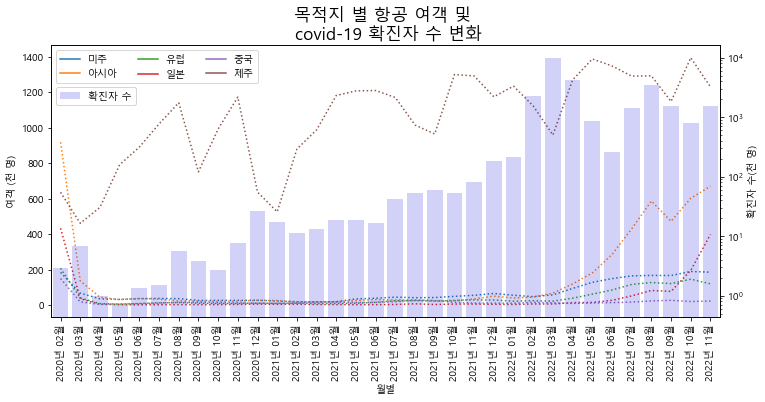

In [17]:
plt.figure(figsize=(12,5))

sns.lineplot(x='시점', y='여객 (천 명)',data=df, hue='지역별', lw=1.5, ls=':')

plt.xticks(rotation=90)
plt.xlabel('월별')
plt.legend(ncol=3, loc=2)

ax2 = plt.twinx()
sns.barplot(x='시점', y='확진자 (천 명)',data=co, ax=ax2, color='blue', alpha=0.2, label='확진자 수')
plt.ylabel('확진자 수(천 명)')
plt.yscale('log')
plt.legend(loc=(0.008,0.78))

plt.title('목적지 별 항공 여객 및 \n covid-19 확진자 수 변화', size=17)

plt.show()

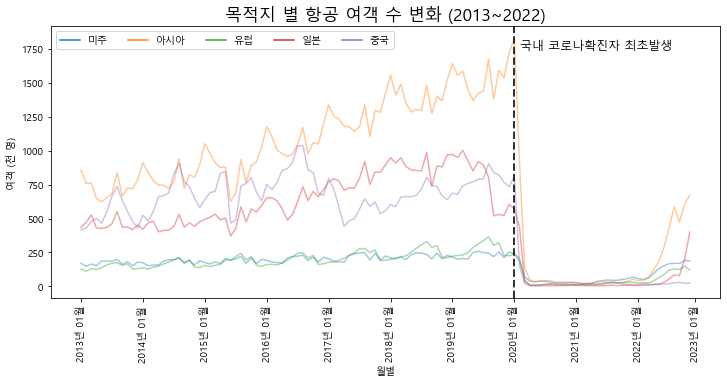

In [18]:
plt.figure(figsize=(12,5))

sns.lineplot(x='시점', y='여객 (천 명)',data=inter_full, hue='지역별', lw=1.5, alpha=0.4)
plt.axvline(x='2020년 01월', color='k', ls='--', lw=2, alpha=0.8)


labels = [f'20{i}년 01월' for i in range(13, 24)]
plt.xticks(labels,rotation=90)
plt.xlabel('월별')
plt.legend(ncol=5, loc=2)

plt.title('목적지 별 항공 여객 수 변화 (2013~2022)', size=17)
plt.text(85, 1750, '국내 코로나확진자 최초발생', color='k', size=12)

plt.show()